# Quickstart Example with Open Bandit Dataset
---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit feedback generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the follwoing four major steps:
- (1) Data Loading and Preprocessing
- (2) Replicating Production Policy
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

In [1]:
# needed when using Google Colab
# !pip install obp

In [1]:
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.5.0


## (1) Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [3]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')

# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the example small-sized version of the Open Bandit Dataset.


the logged bandit feedback is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a \mid x)p(r \mid x,a) $

In [4]:
# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

### let's see some properties of the dataset class

In [5]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [6]:
# number of actions of the "All" campaign is 80
dataset.n_actions

80

In [7]:
# small sample example data has 10,000 samples (or rounds)
dataset.n_rounds

10000

In [8]:
# default context (feature) engineering creates context vector with 20 dimensions
dataset.dim_context

20

In [9]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

## (2) Replicating Production Policy

After preparing the dataset, we now replicate the BernoulliTS policy implemented on the ZOZOTOWN recommendation interface during the data collection period.

Here, we use `obp.policy.BernoulliTS` as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate (the policy parameters of) BernoulliTS used in the ZOZOTOWN production.

(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

In [10]:
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list, 
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)

# compute the action choice probabilities of the evaluation policy using Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

In [11]:
# action_dist is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the evaluation policy
action_dist

array([[[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       ...,

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
  

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

In [12]:
# estimate the expected reward by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LogisticRegression(max_iter=1000, random_state=12345),
)

In [13]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [14]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure.
    random_state=12345,
)

In [15]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy 
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004553,1.198126
dm,0.003385,0.890715
dr,0.004648,1.223175


In [16]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure 
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004544,0.001531,0.009254
dm,0.003385,0.003337,0.003432
dr,0.004639,0.001625,0.009323


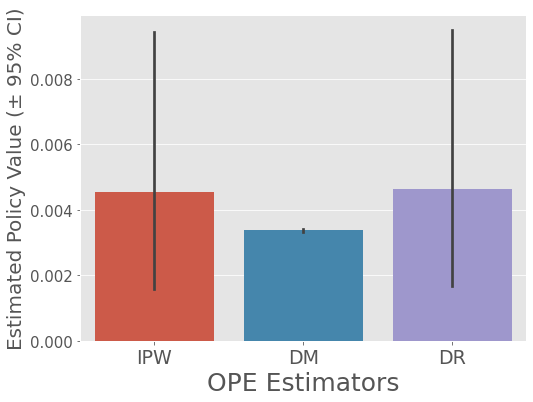

In [17]:
# visualize the policy values of BernoulliTS estimated by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

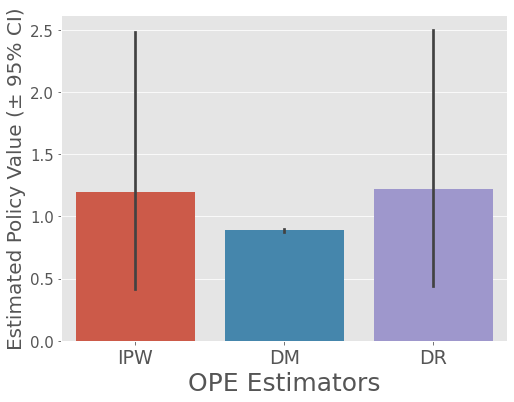

In [18]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 

Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.

## (4) Evaluation of OPE

Our final step is the **evaluation of OPE**, which evaluates the estimation accuracy of OPE estimators.

Specifically, we asses the accuracy of the estimator such as DM, IPW, and DR by comparing its estimation with the ground-truth policy value estimated via the on-policy estimation from the Open Bandit Dataset.

This type of evaluation of OPE is possible, because Open Bandit Dataset contains a set of *multiple* different logged bandit feedback datasets collected by running different policies on the same platform at the same time.

Please refer to [the documentation](https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html) for the details about the evaluation of OPE protocol.

### (4-1) Approximate the Ground-truth Policy Value 
With Open Bandit Dataset, we can estimate the ground-truth policy value of the evaluation policy in an on-policy manner as follows.

$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{e}|} \sum_{i=1}^{|\mathcal{D}_{e}|} \mathbb{E}_{n} [r_i]$

$ \mathcal{D}_e := \{(x_i,a_i,r_i)\} $ ($(x,a,r) \sim p(x)\pi_e(a \mid x)p(r \mid x,a) $) is the log data collected by the evaluation policy (, which is used only for approximating the ground-truth policy value).

We can compare the policy values estimated by OPE estimators with this on-policy estimate to evaluate the accuracy of OPE.

In [19]:
# we first calculate the ground-truth policy value of the evaluation policy
# , which is estimated by averaging the factual (observed) rewards contained in the dataset (on-policy estimation)
policy_value_bts = OpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy='bts', campaign='all'
)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the example small-sized version of the Open Bandit Dataset.


### (4-2) Evaluation of OPE

We can evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)

In [20]:
# evaluate the estimation performance of OPE estimators 
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators 
relative_ee = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee

,relative-ee
ipw,0.084019
dm,0.194115
dr,0.106682


We can iterate the above process several times to get more relibale results.

Please see [examples/obd](../obd) for a more sophisticated example of the evaluation of OPE with the Open Bandit Dataset.